<a href="https://colab.research.google.com/github/DeuklyoungKo/MakeYourFirstGANWithPyTorch/blob/main/ch08_03_face_Discriminator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('./mount')

Drive already mounted at ./mount; to attempt to forcibly remount, call drive.mount("./mount", force_remount=True).


In [13]:
import h5py
import pandas,random, numpy
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

import torch
import torch.nn as nn


##Standard CUDA Check And Set Up

In [14]:
# check if CUDA is available
# if yes, set default tensor type to cuda

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

using cuda: Tesla T4


device(type='cuda')

## 데이터셋

In [15]:
class CelebADataset(Dataset):

  def __init__(self, file):
    self.file_object = h5py.File(file, 'r')
    self.dataset = self.file_object['img_align_celeba']
    pass
  
  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, index):
    if(index >= len(self.dataset)):
      raise IndexError()
    img = numpy.array(self.dataset[str(index)+'.jpg'])
    return torch.cuda.FloatTensor(img) / 255.0

  def plot_image(self, index):
    plt.imshow(numpy.array(self.dataset[str(index)+'.jpg']), interpolation='nearest')
    pass

  pass

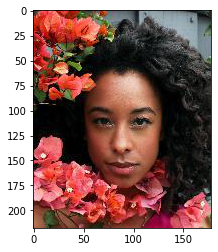

In [16]:
celeba_dataset = CelebADataset('mount/My Drive/Colab Notebooks/Deep Learning/MakeYourFirstGANWithPyTorch/celeba_dataset/celeba_aligned_small.h5py')

celeba_dataset.plot_image(43)

In [17]:
class View(nn.Module):
  def __init__(self, shape):
    super().__init__()
    self.shape = shape,

  def forward(self, x):
    return x.view(*self.shape)

## 판별기

In [18]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    # 신경망 레이어 정의  
    self.model = nn.Sequential(
        View(218*178*3),

        nn.Linear(3*218*178, 100),
        nn.LeakyReLU(),
        nn.LayerNorm(100),
        nn.Linear(100, 1),
        nn.Sigmoid()
    )

    # 손실함수 설정
    # self.loss_function = nn.MSELoss()
    self.loss_function = nn.BCELoss()

    # SGD 옵티마이저 설정
    # self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
    self.optimiser = torch.optim.Adam(self.parameters(), lr=0.001)

    # 진행 측정을 위한 변수 초기화
    self.counter = 0;
    self.progress = []

    pass

  def forward(self, inputs):
    #모델 실행
    return self.model(inputs)

  def train(self, inputs, targets):
    # 신경망 출력 계산
    outputs = self.forward(inputs)

    # 손실 계산
    loss = self.loss_function(outputs, targets)

    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1;
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if (self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass

    # 기울기를 초기화하고 역전파 후 가중치 갱신
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()
    pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
    pass

  def plot_progress2(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
    pass

In [19]:
# 판별기 용
def generate_random_image(size):
  random_data = torch.rand(size)
  return random_data

# 생성기 용
def generate_random_seed(size):
  random_data = torch.randn(size)
  return random_data

In [ ]:
%%time

D = Discriminator()
D.optimiser.param_groups[0]['capturable'] = True
D.to(device)

for image_data_tensor in celeba_dataset:
  D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
  D.train(generate_random_image((218,178,3)), torch.cuda.FloatTensor([0.0]))
  pass